<a href="https://colab.research.google.com/github/shravankumargulvadi/Dwell-Period-implementation-in-One-cycle-LR/blob/master/Dwell_period_Implementation_Example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
! pip install keras-lr-finder keras

In [0]:

import argparse
import logging

import keras
import matplotlib.pyplot as plt
from keras.layers import Dense, Conv2D, BatchNormalization, Activation
from keras.layers import AveragePooling2D, Input, Flatten
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.callbacks import ReduceLROnPlateau
from keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2
from keras.models import Model
import keras.backend as K
from keras.datasets import cifar10
import numpy as np
import os

from keras_lr_finder import LRFinder

logging.basicConfig(level=logging.INFO)
np.random.seed(5)

# Training parameters
batch_size = 512  # orig paper trained all networks with batch_size=128
epochs = 100
data_augmentation = True
num_classes = 10
n = 3
depth = n * 6 + 2
weightDecay=0.0001
logging.info(f'Running experiment with following training parameters:\n  batch_size:{batch_size}\n'
             f' epochs:{epochs}\n   data_augmentation:\n        -Add 4 pixel padding and random crop by 32,32'
             f'\n       -Horizontal flip\n  weigthDecay:{weightDecay}\n    NormalizeData:True\n'
             f' StandardiseData:True')

# Model name, depth and version
model_type = 'ResNet%dv%d' % (depth, 1)

# Load the CIFAR10 data.
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# Input image dimensions.
input_shape = x_train.shape[1:]
print(input_shape)
print(x_train.shape)

# Normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255


print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)

# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):
    """2D Convolution-Batch Normalization-Activation stack builder

    # Arguments
        inputs (tensor): input tensor from input image or previous layer
        num_filters (int): Conv2D number of filters
        kernel_size (int): Conv2D square kernel dimensions
        strides (int): Conv2D square stride dimensions
        activation (string): activation name
        batch_normalization (bool): whether to include batch normalization
        conv_first (bool): conv-bn-activation (True) or
            bn-activation-conv (False)

    # Returns
        x (tensor): tensor as input to the next layer
    """
    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(input_shape, depth, num_classes=10):
    """ResNet Version 1 Model builder [a]

    Stacks of 2 x (3 x 3) Conv2D-BN-ReLU
    Last ReLU is after the shortcut connection.
    At the beginning of each stage, the feature map size is halved (downsampled)
    by a convolutional layer with strides=2, while the number of filters is
    doubled. Within each stage, the layers have the same number filters and the
    same number of filters.
    Features maps sizes:
    stage 0: 32x32, 16
    stage 1: 16x16, 32
    stage 2:  8x8,  64
    The Number of parameters is approx the same as Table 6 of [a]:
    ResNet20 0.27M
    ResNet32 0.46M
    ResNet44 0.66M
    ResNet56 0.85M
    ResNet110 1.7M

    # Arguments
        input_shape (tensor): shape of input image tensor
        depth (int): number of core convolutional layers
        num_classes (int): number of classes (CIFAR10 has 10)

    # Returns
        model (Model): Keras model instance
    """
    if (depth - 2) % 6 != 0:
        raise ValueError('depth should be 6n+2 (eg 20, 32, 44 in [a])')
    # Start model definition.
    num_filters = 16
    num_res_blocks = int((depth - 2) / 6)

    inputs = Input(shape=input_shape)
    x = resnet_layer(inputs=inputs)
    # Instantiate the stack of residual units
    for stack in range(3):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=num_filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
        num_filters *= 2

    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=8)(x)
    y = Flatten()(x)
    outputs = Dense(num_classes,
                    activation='softmax',
                    kernel_initializer='he_normal')(y)

    # Instantiate model.
    model = Model(inputs=inputs, outputs=outputs)
    return model


model = resnet_v1(input_shape=input_shape, depth=depth)

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])
model.summary()

Using TensorFlow backend.


170500096/170498071 [==============================] - 2s 0us/step
(32, 32, 3)
(50000, 32, 32, 3)


W0823 10:46:26.923032 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0823 10:46:26.955653 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0823 10:46:26.962707 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0823 10:46:27.005339 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0823 10:46:27.006191

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)


W0823 10:46:29.760647 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0823 10:46:31.502422 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W0823 10:46:31.532299 139918659491712 deprecation_wrapper.py:119] From /usr/local/lib/python3.6/dist-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 16)   448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 32, 32, 16)   64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 32, 32, 16)   0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
conv2d_2 (

W0823 10:46:33.456829 139918659491712 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/1
50000/50000 [==============================] - 18s 352us/step - loss: 3.6063 - acc: 0.1465
ma_lr=
0.045962133


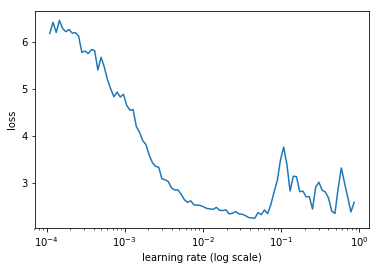

In [0]:
# LR finder
# model is a Keras model
lr_finder = LRFinder(model)

# Train a model with batch size 512 for 5 epochs
# with learning rate growing exponentially from 0.0001 to 1
lr_finder.find(x_train, y_train, start_lr=0.0001, end_lr=1, batch_size=512, epochs=1)
lr_finder.plot_loss(n_skip_beginning=1, n_skip_end=1)
print('ma_lr=')
print(lr_finder.lrs[np.argmin(lr_finder.losses)])
model.save_weights('lr experiments')

In [0]:
def cutout(img):
        """
        Args:
            img (Tensor): Tensor image of size (C, H, W).
        Returns:
            Tensor: Image with n_holes of dimension length x length cut out of it.
        """
        n_holes=1
        length=8
        img= np.array(img)
        h = img.shape[0]
        w = img.shape[1]
        

        mask = np.ones((h, w, 3), np.float32)

        for n in range(n_holes):
            y = np.random.randint(h)
            x = np.random.randint(w)

            y1 = int(np.clip(y - length // 2, 0, h))
            y2 = int(np.clip(y + length // 2, 0, h))
            x1 = int(np.clip(x - length // 2, 0, w))
            x2 = int(np.clip(x + length // 2, 0, w))

            mask[y1: y2, x1: x2] = 0.
            #print(mask, img.shape, y, x )
       
        img = img * mask
        return img

## Dwell Period implementation 

In [0]:
from sklearn.metrics import log_loss, roc_auc_score, accuracy_score
from keras.losses import binary_crossentropy
from keras.metrics import binary_accuracy
from keras import backend as K
from keras.callbacks import *
import keras
import numpy as np


class CustomOnecycle(keras.callbacks.Callback):
   def __init__(self,max_lr,min_lr,epoch_peak,batch_size,epoch,train_size,dwell_portion):
 
        self.max_lr = max_lr
        self.min_lr = min_lr
        self.epoch_peak = epoch_peak
        self.train_size=train_size
        self.batch_size=batch_size
        self.peak_iteration=int(self.epoch_peak*(train_size/batch_size))
        self.max_iteration=epoch*(train_size/batch_size)
        self.clr_iterations=0
        self.lrlist=[]
        self.batchlist=[]
        self.dwell_end_iter=self.peak_iteration+int((self.max_iteration-self.peak_iteration)*dwell_portion)
        
        print('dwell end iter=')
        print(self.dwell_end_iter)
   
   def clr(self, i):
       print()
       self.batchlist.append(i)
   
       if i <self.peak_iteration:
          lr=(i*((self.max_lr-self.min_lr)/(self.peak_iteration-1)))+self.min_lr
       
       elif self.peak_iteration<=i<self.dwell_end_iter:
          lr=self.max_lr
          
        
          
       else:
          lr=((i-self.dwell_end_iter)*((self.min_lr-self.max_lr)/(self.max_iteration-self.dwell_end_iter)))+self.max_lr
         
       return lr
      
    
        
  
   def on_batch_begin(self, batch, logs=None):
        
        
        logs = logs or {}
     
        self.clr_iterations += 1
        lr=self.clr(self.clr_iterations)
        self.lrlist.append(lr)
        print('iter=')
        print(self.clr_iterations)
        print('lr=')
        print(lr)
       

        
       
        K.set_value(self.model.optimizer.lr, lr)
        

## Instruction
dwell_portion is the portion of downhill LR You want to convert to Dwell region

In [0]:
model_1 = resnet_v1(input_shape=input_shape, depth=depth)
from keras.optimizers import Adam, SGD
model_1.load_weights('lr experiments')
model_1.compile(loss='categorical_crossentropy',
              optimizer=SGD(decay=0.001),
              metrics=['accuracy'])
model_1.summary()

max_lr=0.7
min_lr=max_lr/10
epoch_peak=7
epochs=24
batch_size=512

clr=CustomOnecycle(max_lr=max_lr,min_lr=min_lr,epoch_peak=epoch_peak,batch_size=batch_size,epoch=epochs,train_size=50000, dwell_portion=0.3)



callbacks = [clr, ModelCheckpoint(filepath='best_model.h5', monitor='val_acc',mode='max',verbose=1,save_best_only=True)]


from keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(zoom_range=0.0, 
                             horizontal_flip=False, preprocessing_function=cutout)
# train the model
start = time.time()
# Train the model
model_info = model_1.fit_generator(datagen.flow(x_train, y_train, batch_size = batch_size), samples_per_epoch = y_train.shape[0], nb_epoch = epochs, validation_data = (x_test, y_test), verbose=1, callbacks=callbacks)
end = time.time()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_13 (InputLayer)           (None, 32, 32, 3)    0                                            
__________________________________________________________________________________________________
conv2d_253 (Conv2D)             (None, 32, 32, 16)   448         input_13[0][0]                   
__________________________________________________________________________________________________
batch_normalization_229 (BatchN (None, 32, 32, 16)   64          conv2d_253[0][0]                 
__________________________________________________________________________________________________
activation_229 (Activation)     (None, 32, 32, 16)   0           batch_normalization_229[0][0]    
__________________________________________________________________________________________________
conv2d_254

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:29: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<keras_pre..., validation_data=(array([[[..., verbose=1, callbacks=[<__main__..., steps_per_epoch=97, epochs=24)`


Epoch 1/24

iter=
1
lr=
0.07092375366568915
 1/97 [..............................] - ETA: 14:49 - loss: 6.3400 - acc: 0.1113
iter=
2
lr=
0.07184750733137829
 2/97 [..............................] - ETA: 7:27 - loss: 5.1690 - acc: 0.1250 
iter=
3
lr=
0.07277126099706745


/usr/local/lib/python3.6/dist-packages/keras/callbacks.py:99: UserWarning: Method on_batch_begin() is slow compared to the batch update (3.449278). Check your callbacks.
  % delta_t_median)


 3/97 [..............................] - ETA: 4:58 - loss: 4.7127 - acc: 0.1243
iter=
4
lr=
0.07369501466275659
 4/97 [>.............................] - ETA: 3:44 - loss: 4.3671 - acc: 0.1211
iter=
5
lr=
0.07461876832844574
 5/97 [>.............................] - ETA: 3:00 - loss: 4.0983 - acc: 0.1328
iter=
6
lr=
0.07554252199413489
 6/97 [>.............................] - ETA: 2:30 - loss: 3.8838 - acc: 0.1364
iter=
7
lr=
0.07646627565982404
 7/97 [=>............................] - ETA: 2:09 - loss: 3.7193 - acc: 0.1431
iter=
8
lr=
0.07739002932551318
 8/97 [=>............................] - ETA: 1:53 - loss: 3.5806 - acc: 0.1436
iter=
9
lr=
0.07831378299120234
 9/97 [=>............................] - ETA: 1:40 - loss: 3.4596 - acc: 0.1521
iter=
10
lr=
0.07923753665689148
10/97 [==>...........................] - ETA: 1:30 - loss: 3.3645 - acc: 0.1561
iter=
11
lr=
0.08016129032258064
11/97 [==>...........................] - ETA: 1:22 - loss: 3.2706 - acc: 0.1637
iter=
12
lr=
0.0810850

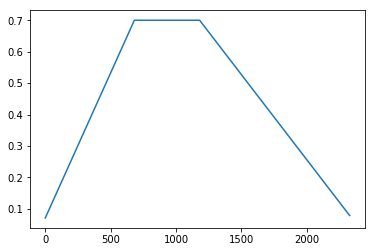

In [0]:
plt.plot(clr.batchlist,clr.lrlist)